# Algo Trading News or Noise

## Imports
---

In [94]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import hvplot.pandas
from dotenv import load_dotenv
import panel as pn
from panel.interact import interact
from panel import widgets
import alpaca_trade_api as tradeapi
import quandl
import os
import requests
import ccxt
import time
import tensorflow

## Read in data
---

In [95]:
ETF_csv = Path("Resources/ETFs_changes_ichi.csv")
ETF_df = pd.read_csv(ETF_csv, index_col='Unnamed: 0', infer_datetime_format=True, parse_dates=True)
ETF_df = ETF_df.drop(ETF_df.index[0])
ETF_df.index = pd.to_datetime(ETF_df.index, utc=True).date
ETF_df.sort_index(inplace=True)
ETF_df.tail()

,SPY_low,SPY_high,SPY,XLF,XLK,XLU,XLI,XLV,XLY,XLP,...,XRT,ETH,LTC,GME_high,GME_low,GME,BB,MT,PLTR,SNDL
2021-01-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,45.520000,36.639999,39.360001,12.350000,22.959999,26.340000,0.681
2021-01-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,41.189999,36.060001,39.119999,12.790000,23.469999,25.980000,0.661
2021-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,44.750000,37.000000,43.029999,12.850000,23.120001,32.580002,0.645
2021-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,76.760002,42.320000,65.010002,14.040000,22.430000,36.230000,0.600
2021-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,159.179993,61.130001,76.790001,18.030001,21.990000,35.369999,0.560


## Set analysis inputs
---


In [96]:
ticker = input("Please enter the symbol name in caps:\n")

# Set intial capital
initial_capital = input("Please input the amount of capital you have (USD):\n")
initial_capital = int(initial_capital)

# Set lot size
share_size = input("Please input the lot size you wish to trade:\n")
share_size = int(share_size)

# Set windows
short_window = input("Please choose a short moving average lookback window: 20, 50 days\n")
short_window = int(short_window)
long_window = input("Please choose a long moving average lookback window: 100, 200 days\n")
long_window = int(long_window)
bollinger_window = input("Please choose a 10, 20, 50 bollinger lookback window\n")
bollinger_window = int(bollinger_window)

Please enter the symbol name in caps:
 GME
Please input the amount of capital you have (USD):
 10000
Please input the lot size you wish to trade:
 100
Please choose a short moving average lookback window: 20, 50 days
 50
Please choose a long moving average lookback window: 100, 200 days
 200
Please choose a 10, 20, 50 bollinger lookback window
 20



## Signal generation
---
### SMA
*Simple Moving Average for a given lookback window*

In [97]:
# Grab `ticker` from the dataset
SMA_df = ETF_df[f'{ticker}'].copy().to_frame()

In [98]:
# Generate the short and long moving averages (50 and 100 days, respectively)
SMA_df["SMA_short"] = SMA_df[{ticker}].rolling(window=short_window).mean()
SMA_df["SMA_long"] = SMA_df[{ticker}].rolling(window=long_window).mean()

In [99]:
# Initialize the new `Signal` column
SMA_df["signal"] = 0.0

# Generate the trading signal -1, 1,
# where -1 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
SMA_df["signal"][short_window:] = np.where(
    SMA_df["SMA_short"][short_window:] < SMA_df["SMA_long"][short_window:], -1.0, 1.0
)

In [100]:
# Calculate the points in time at which a position should be taken, 1 or -1
SMA_df["entry/exit"] = SMA_df["signal"].diff()

In [101]:
# Tidy up
SMA_df.dropna(inplace=True)
SMA_df.tail()

,GME,SMA_short,SMA_long,signal,entry/exit
2021-01-19,39.360001,17.0966,9.05055,1.0,0.0
2021-01-20,39.119999,17.6500,9.23215,1.0,0.0
2021-01-21,43.029999,18.2734,9.43185,1.0,0.0
2021-01-22,65.010002,19.3438,9.74055,1.0,0.0
2021-01-25,76.790001,20.6576,10.10745,1.0,0.0


---
### EMA
*Exponential-weighted Moving Average for a given lookback window*

In [102]:
# Grab `ticker` from the dataset
EMA_df = ETF_df[f'{ticker}'].copy().to_frame()

In [103]:
# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
EMA_df['EMA_short'] = EMA_df[{ticker}].ewm(halflife=short_window).mean()
EMA_df['EMA_long'] = EMA_df[{ticker}].ewm(halflife=long_window).mean()

In [104]:
# Initialize signal column
EMA_df["signal"] = 0.0

# Construct a crossover trading signal
# where -1 is when the EMA50 is under the EMA200, and
# where 1 is when the EMA50 is higher (or crosses over) the EMA200
EMA_df["signal"][short_window:] = np.where(
    EMA_df["EMA_short"][short_window:] < EMA_df["EMA_long"][short_window:], -1.0, 1.0
)

In [105]:
# Calculate the points in time at which a position should be taken, 1 or -1
EMA_df["entry/exit"] = EMA_df["signal"].diff()

In [106]:
# Tidy up
EMA_df.dropna(inplace=True)
EMA_df.tail()

,GME,EMA_short,EMA_long,signal,entry/exit
2021-01-19,39.360001,12.821249,10.323112,1.0,0.0
2021-01-20,39.119999,13.183312,10.422748,1.0,0.0
2021-01-21,43.029999,13.594220,10.535568,1.0,0.0
2021-01-22,65.010002,14.302076,10.724048,1.0,0.0
2021-01-25,76.790001,15.162366,10.952633,1.0,0.0


---
### BBD
*Bollinger Bands for a given lookback window*

In [107]:
# Grab `ticker` from the dataset
BBD_df = ETF_df[f'{ticker}'].copy().to_frame()

In [108]:
# Calculate rolling mean and standard deviation
BBD_df['BBD_mid'] = BBD_df[{ticker}].rolling(window=bollinger_window).mean()
BBD_df['BBD_std'] = BBD_df[{ticker}].rolling(window=bollinger_window).std()

In [109]:
# Calculate upper and lowers bands of bollinger band
BBD_df['BBD_upper']  = BBD_df['BBD_mid'] + (BBD_df['BBD_std'] * 1)
BBD_df['BBD_lower']  = BBD_df['BBD_mid'] - (BBD_df['BBD_std'] * 1)

In [110]:
# Construct a crossover trading signal
# where 1 is when the close is under the lower bound, and
# where -1 is when the close is higher the upper bound
BBD_df['long'] = np.where(BBD_df[f'{ticker}'] < BBD_df['BBD_lower'], 1.0, 0.0)
BBD_df['short'] = np.where(BBD_df[f'{ticker}'] > BBD_df['BBD_upper'], -1.0, 0.0)

In [111]:
# Calculate bollinger band trading signal
BBD_df['signal'] = BBD_df['long'] + BBD_df['short']
BBD_df["entry/exit"] = BBD_df["signal"].diff()

In [112]:
# Tidy up
BBD_df.dropna(inplace=True)
BBD_df.tail()

,GME,BBD_mid,BBD_std,BBD_upper,BBD_lower,long,short,signal,entry/exit
2021-01-19,39.360001,22.2310,7.646990,29.877990,14.584010,0.0,-1.0,-1.0,0.0
2021-01-20,39.119999,23.4055,8.351264,31.756764,15.054236,0.0,-1.0,-1.0,0.0
2021-01-21,43.029999,24.7805,9.206444,33.986944,15.574056,0.0,-1.0,-1.0,0.0
2021-01-22,65.010002,27.0580,12.766689,39.824689,14.291311,0.0,-1.0,-1.0,0.0
2021-01-25,76.790001,29.8690,16.811528,46.680528,13.057472,0.0,-1.0,-1.0,0.0


---
### RSI
*Relative Strength Index for a given lookback window*

In [113]:
# Calculate daily change
RSI_df = ETF_df[f'{ticker}'].copy().to_frame()
RSI_df['change'] = RSI_df[f'{ticker}'].diff(1)

# Caculate gain / loss from every changes and add as column to RSI_df
RSI_df['gain'] = np.select([RSI_df['change']>0, RSI_df['change'].isna()],
                       [RSI_df['change'], np.nan],
                       default=0)
RSI_df['loss'] = np.select([RSI_df['change']<0, RSI_df['change'].isna()],
                       [RSI_df['change'], np.nan],
                       default=0)

# Create avg_gain / avg_loss columns with all nan
RSI_df['avg_gain'] = np.nan
RSI_df['avg_loss'] = np.nan

# Set the window (in this example we are using 14 days, should we make this an input as well?)
n = 14

# calculate rolling 14 day avg or gains and losses and add to the avg_gain and avg_loss columns
RSI_df['avg_gain'][n] = RSI_df['gain'].rolling(window=n).mean().dropna().iloc[0]
RSI_df['avg_loss'][n] = RSI_df['loss'].rolling(window=n).mean().dropna().iloc[0]
for i in range(n+1, RSI_df.shape[0]):
    RSI_df['avg_gain'].iloc[i] = (RSI_df['avg_gain'].iloc[i-1] * (n - 1) + RSI_df['gain'].iloc[i]) / n
    RSI_df['avg_loss'].iloc[i] = (RSI_df['avg_loss'].iloc[i-1] * (n - 1) + RSI_df['loss'].iloc[i]) / n

    # Calculate RS and RSI
RSI_df['rs'] = abs(RSI_df['avg_gain'] / RSI_df['avg_loss'])
RSI_df['RSI'] = 100 - (100 / (1 + RSI_df['rs'] ))
RSI_df.head(25)
# Initialize the new `Signal` column
RSI_df["signal"] = 0.0
RSI_df.head()

# Generate the trading signal -1, 1,
# where -1 is when the RSI is above 70
# where 1 is when the RSI is below 30
for i in range(0, len(RSI_df)):
    if RSI_df['RSI'].iloc[i] > 70:
        RSI_df['signal'].iloc[i] = -1
    elif RSI_df['RSI'].iloc[i] < 30:
        RSI_df['signal'].iloc[i] = 1
    else:
        RSI_df['signal'].iloc[i] = 0
RSI_df.head(50)

# Calculate the points in time at which a position should be taken, 1 or -1
RSI_df["entry/exit"] = RSI_df["signal"]
RSI_df.tail()

,GME,change,gain,loss,avg_gain,avg_loss,rs,RSI,signal,entry/exit
2021-01-19,39.360001,3.860001,3.860001,0.000000,1.844298,-0.529326,3.484239,77.699672,-1.0,-1.0
2021-01-20,39.119999,-0.240002,0.000000,-0.240002,1.712563,-0.508660,3.366812,77.100000,-1.0,-1.0
2021-01-21,43.029999,3.910000,3.910000,0.000000,1.869522,-0.472327,3.958109,79.831022,-1.0,-1.0
2021-01-22,65.010002,21.980003,21.980003,0.000000,3.305985,-0.438589,7.537767,88.287336,-1.0,-1.0
2021-01-25,76.790001,11.779999,11.779999,0.000000,3.911272,-0.407262,9.603831,90.569446,-1.0,-1.0


---
### Ichimoku
*Collection of indicators showing support and resistance as well as momentum and trend direction*

In [116]:
########################### TO DO ########################### 
ichi_df = ETF_df[f'{ticker}'].copy().to_frame()
ichi_df[f'{ticker}_high'] = ETF_df[f'{ticker}_high'].copy().to_frame()
ichi_df[f'{ticker}_low'] = ETF_df[f'{ticker}_low'].copy().to_frame()
ichi_df

,GME,GME_high,GME_low
2010-01-05,23.520000,23.740000,22.900000
2010-01-06,24.030001,24.100000,23.219999
2010-01-07,20.459999,21.170000,19.420000
2010-01-08,20.290001,21.230000,20.230000
2010-01-11,20.320000,20.590000,20.110001
...,...,...,...
2021-01-19,39.360001,45.520000,36.639999
2021-01-20,39.119999,41.189999,36.060001
2021-01-21,43.029999,44.750000,37.000000
2021-01-22,65.010002,76.760002,42.320000


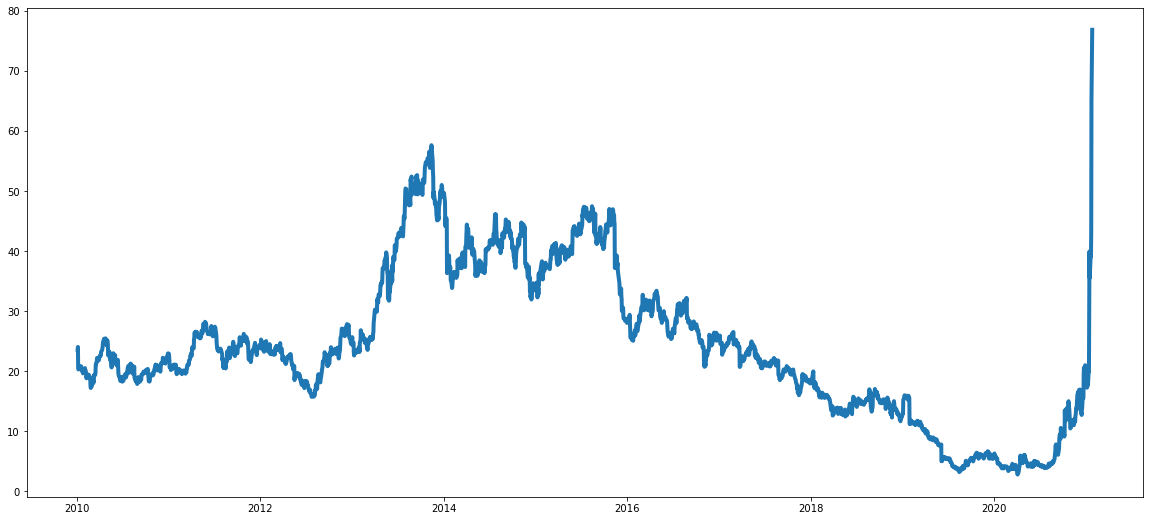

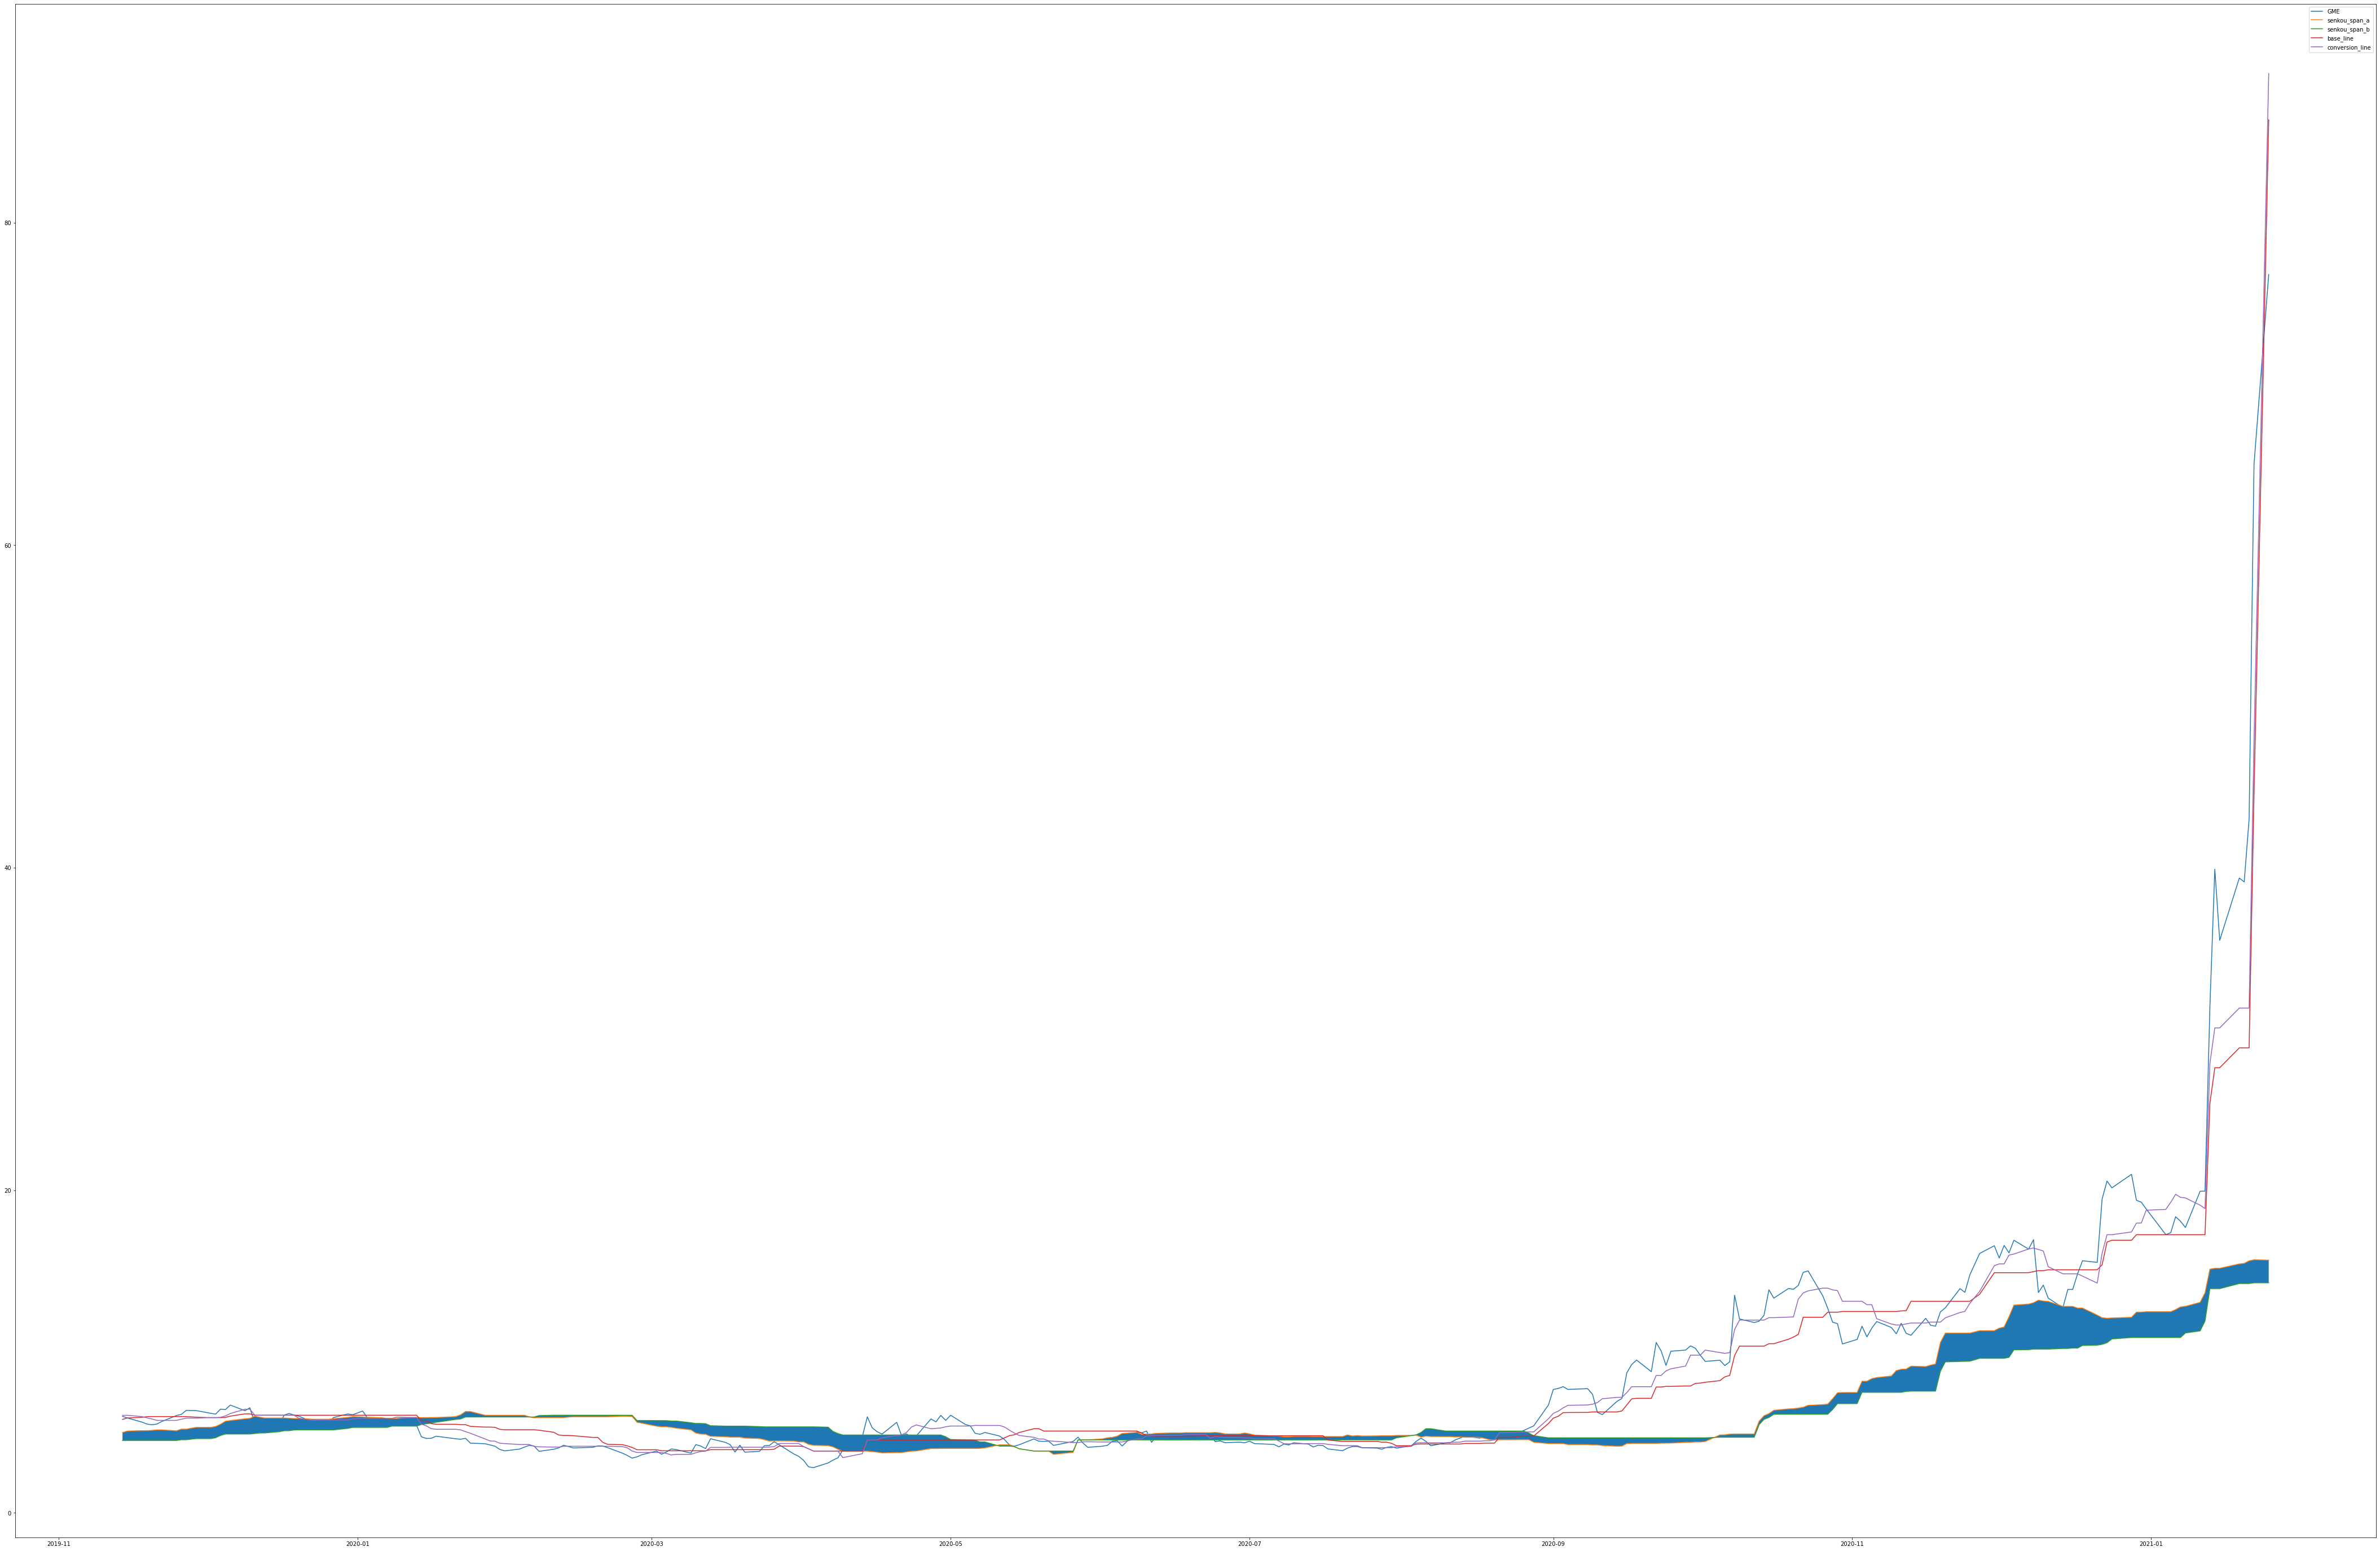

In [117]:
high_9 = ichi_df[f'{ticker}_high'].rolling(window= 9, min_periods = 0).max()
low_9 =  ichi_df[f'{ticker}_low'].rolling(window= 9, min_periods = 0).min()
ichi_df['conversion_line'] = (high_9 + low_9) /2

high_26 = ichi_df[f'{ticker}_high'].rolling(window= 26, min_periods = 0).max()
low_26 = ichi_df[f'{ticker}_low'].rolling(window= 26, min_periods = 0).min()
ichi_df['base_line'] = (high_26 + low_26) / 2

ichi_df['senkou_span_a'] = ((ichi_df['conversion_line'] + ichi_df['base_line']) / 2).shift(30)

high_52 = ichi_df[f'{ticker}_high'].rolling(window= 52, min_periods = 0).max()
low_52 = ichi_df[f'{ticker}_low'].rolling(window= 52, min_periods = 0).min()
ichi_df['senkou_span_b'] = ((high_52 + low_52) / 2).shift(30)

ichi_df['lagging_span'] = ichi_df[f'{ticker}'].shift(-30)

fig,ax = plt.subplots(1,1,sharex=True,figsize = (20,9)) #share x axis and set a figure size
ax.plot(ichi_df.index, ichi_df[f'{ticker}'],linewidth=4) # plot Close with index on x-axis with a line thickness of 4
tmp = ichi_df[[f'{ticker}','senkou_span_a','senkou_span_b','base_line','conversion_line']].tail(300)
a1 = tmp.plot(figsize=(75,50))
a1.fill_between(tmp.index, tmp.senkou_span_a, tmp.senkou_span_b)
# use the fill_between call of ax object to specify where to fill the chosen color
# pay attention to the conditions specified in the fill_between call
# ax.fill_between(ETF_df.index,['leading_span_A'],ETF_df['leading_span_B'],where = ETF_df['leading_span_A'] >= ETF_df['leading_span_B'], color = 'lightgreen')
# ax.fill_between(ETF_df.index,ETF_df['leading_span_A'],ETF_df['leading_span_B'],where = ['leading_span_A'] < ETF_df['leading_span_B'], color = 'lightcoral')

## Backtesting
---
### Simulated portfolio
*Evaluate historic signal performance*

In [118]:
# Create function to pass through signal df's, share size, initial capital, and ticker of chosen security
def signal_position(df, share_size, initial_capital, ticker):
    # Take a 500 share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
    df['position'] = share_size * df['signal']
    # Find the points in time where a 500 share position is bought or sold
    df["entry/exit position"] = df["position"].diff()
    # Multiply share price by entry/exit positions and get the cumulatively sum
    df["portfolio holdings"] = (df[f'{ticker}'] * df["entry/exit position"].cumsum())
    # Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
    df["portfolio cash"] = (initial_capital - (df[f'{ticker}'] * df["entry/exit position"]).cumsum())
    # Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
    df["portfolio total"] = (df["portfolio cash"] + df["portfolio holdings"])
    # Calculate the portfolio daily returns
    df["portfolio daily returns"] = df["portfolio total"].pct_change()
    # Calculate the cumulative returns
    df["portfolio cumulative returns"] = (1 + df["portfolio daily returns"]).cumprod() - 1
    # Tidy up and drop N/A
    df.dropna(inplace=True)
    return df
    
SMA_df = signal_position(SMA_df, share_size, initial_capital, ticker)
EMA_df = signal_position(EMA_df, share_size, initial_capital, ticker)
BBD_df = signal_position(BBD_df, share_size, initial_capital, ticker)
RSI_df = signal_position(RSI_df, share_size, initial_capital, ticker)

In [119]:
# Create cumulative returns df with all signals
cumulative_returns_df = pd.concat([SMA_df['portfolio cumulative returns'],
                        EMA_df['portfolio cumulative returns'],
                        BBD_df['portfolio cumulative returns'],
                        RSI_df['portfolio cumulative returns']
                       ], axis=1)
cumulative_returns_df.columns = ['SMA', 'EMA', 'BBD', 'RSI']
cumulative_returns_df.index.name = f'{ticker}'
cumulative_returns_df.dropna(inplace=True)
cumulative_returns_df.head()

,SMA,EMA,BBD,RSI
GME,,,,
2010-10-21,0.0,-0.0364,-0.0932,-0.0077
2010-10-22,0.0,-0.0373,-0.0932,-0.0077
2010-10-25,0.0,-0.0383,-0.0932,-0.0077
2010-10-26,0.0,-0.0400,-0.0932,-0.0077
2010-10-27,0.0,-0.0398,-0.0932,-0.0077


<AxesSubplot:title={'center':'Cumulative Returns'}, xlabel='GME'>

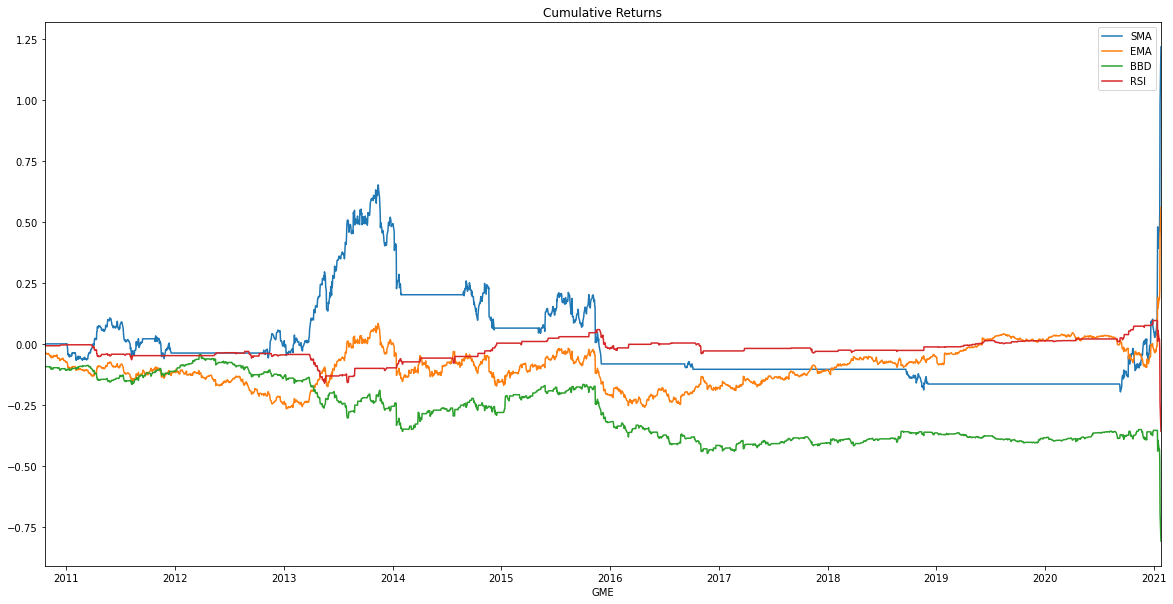

In [120]:
# Plot cumulative returns
# YOUR CODE HERE
cumulative_returns_df.plot(figsize=(20, 10), xlim=(cumulative_returns_df.index.min(),cumulative_returns_df.index.max()), title="Cumulative Returns")
#combined_strategies_cumulative_returns_df.describe()

---
### Descriptive statistics
*Evaluate backtesting*

In [121]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return (%)',
    'Cumulative Returns (%)',
    'Annual Volatility (%)',
    'Sharpe Ratio',
    'Sortino Ratio',
    'Max Drawdown (%)']

columns = ['SMA', 'EMA', 'BBD', 'RSI', 'MACD']

In [122]:
def evalll_df(ticker):
    eval_df = pd.DataFrame(index=metrics, columns=columns)
    eval_df.index.name = f'{ticker}' 
        
    def evall_df(df, signal, ticker):
        eval_df.loc['Cumulative Returns (%)', signal] = round(df['portfolio cumulative returns'][-1],2)
        eval_df.loc['Annual Return (%)', signal] = round((df['portfolio daily returns'].mean() * 252),2)
        eval_df.loc['Annual Volatility (%)', signal] = round(df['portfolio daily returns'].std() * np.sqrt(252),2)
        eval_df.loc['Sharpe Ratio', signal] = round((df['portfolio daily returns'].mean() * 252) / (df['portfolio daily returns'].std() * np.sqrt(252)), 2)
        df.loc[:,'downside returns'] = 0
        df_mask = df['portfolio daily returns'] < 0
        df.loc[df_mask, 'downside returns'] = df['portfolio daily returns']**2
        df_sortino = (df['portfolio daily returns'].mean() * 252) / (np.sqrt(df['downside returns'].mean()) * np.sqrt(252))
        eval_df.loc['Sortino Ratio', signal] = round(df_sortino,2)
        eval_df.loc['Max Drawdown (%)', signal] = round(df['portfolio cumulative returns'].diff(short_window).min(),2)
        return eval_df
    eval_df.loc[['Cumulative Returns (%)', 'Annual Return (%)', 'Annual Volatility (%)', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown (%)'],
               ['SMA']] = evall_df(SMA_df, 'SMA', ticker)
    eval_df.loc[['Cumulative Returns (%)', 'Annual Return (%)', 'Annual Volatility (%)', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown (%)'],
               ['EMA']] = evall_df(EMA_df, 'EMA', ticker) 
    eval_df.loc[['Cumulative Returns (%)', 'Annual Return (%)', 'Annual Volatility (%)', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown (%)'],
               ['BBD']] = evall_df(BBD_df, 'BBD', ticker)
    eval_df.loc[['Cumulative Returns (%)', 'Annual Return (%)', 'Annual Volatility (%)', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown (%)'],
               ['RSI']] = evall_df(RSI_df, 'RSI', ticker)
    return eval_df

evalll_df(ticker)

,SMA,EMA,BBD,RSI,MACD
GME,,,,,
Annual Return (%),0.1,0.05,-0.12,-0.04,NaN
Cumulative Returns (%),1.22,0.56,-0.81,-0.36,NaN
Annual Volatility (%),0.19,0.14,0.21,0.1,NaN
Sharpe Ratio,0.49,0.35,-0.58,-0.37,NaN
Sortino Ratio,0.86,0.57,-0.62,-0.39,NaN
Max Drawdown (%),-0.45,-0.22,-0.45,-0.43,NaN


## Deep learning
---
### Signals df

In [123]:
# Combine signals
signals_df = pd.concat([SMA_df['signal'],
                        EMA_df['signal'],
                        BBD_df['signal'],
                        RSI_df['signal']
                       ], axis=1)
signals_df.columns = ['SMA', 'EMA', 'BBD', 'RSI']
signals_df.index.name = f'{ticker}'
signals_df.dropna(inplace=True)

In [124]:
# Shift signals data by 1 in order to prime for predictions
signals_df = signals_df.shift(1)

In [125]:
# Set dependant variable
signals_df['daily return'] = ETF_df[f'{ticker}'].pct_change(short_window)
signals_df['positive return'] = np.where(signals_df['daily return'] > 0, 1.0, 0.0)
signals_df['negative return'] = np.where(signals_df['daily return'] < 0, -1.0, 0.0)
signals_df['ACTUAL'] = signals_df['positive return'] + signals_df['negative return']
signals_df.drop(columns=['positive return', 'negative return', 'daily return'], inplace=True)
signals_df.dropna(inplace=True)
signals_df.tail()

,SMA,EMA,BBD,RSI,ACTUAL
GME,,,,,
2021-01-19,1.0,1.0,-1.0,-1.0,1.0
2021-01-20,1.0,1.0,-1.0,-1.0,1.0
2021-01-21,1.0,1.0,-1.0,-1.0,1.0
2021-01-22,1.0,1.0,-1.0,-1.0,1.0
2021-01-25,1.0,1.0,-1.0,-1.0,1.0


In [126]:
# Construct training start and end dates

---
### Features df

In [127]:
# Combine signals
features_df = pd.concat([ETF_df[f'{ticker}'], 
                        SMA_df['SMA_long'], SMA_df['SMA_short'],
                        EMA_df['EMA_long'], EMA_df['EMA_short'],
                        BBD_df['BBD_mid'], BBD_df['BBD_std'], BBD_df['BBD_upper'], BBD_df['BBD_lower'],
                        RSI_df['RSI']
                       ], axis=1)

In [128]:
features_df.dropna(inplace=True)
features_df.tail()

,GME,SMA_long,SMA_short,EMA_long,EMA_short,BBD_mid,BBD_std,BBD_upper,BBD_lower,RSI
2021-01-19,39.360001,9.05055,17.0966,10.323112,12.821249,22.2310,7.646990,29.877990,14.584010,77.699672
2021-01-20,39.119999,9.23215,17.6500,10.422748,13.183312,23.4055,8.351264,31.756764,15.054236,77.100000
2021-01-21,43.029999,9.43185,18.2734,10.535568,13.594220,24.7805,9.206444,33.986944,15.574056,79.831022
2021-01-22,65.010002,9.74055,19.3438,10.724048,14.302076,27.0580,12.766689,39.824689,14.291311,88.287336
2021-01-25,76.790001,10.10745,20.6576,10.952633,15.162366,29.8690,16.811528,46.680528,13.057472,90.569446


In [129]:
# Looking for missing values
features_df.isnull().sum().sum()

0

In [130]:
features_df.reset_index(inplace=True)
features_df.tail()

,index,GME,SMA_long,SMA_short,EMA_long,EMA_short,BBD_mid,BBD_std,BBD_upper,BBD_lower,RSI
2577,2021-01-19,39.360001,9.05055,17.0966,10.323112,12.821249,22.2310,7.646990,29.877990,14.584010,77.699672
2578,2021-01-20,39.119999,9.23215,17.6500,10.422748,13.183312,23.4055,8.351264,31.756764,15.054236,77.100000
2579,2021-01-21,43.029999,9.43185,18.2734,10.535568,13.594220,24.7805,9.206444,33.986944,15.574056,79.831022
2580,2021-01-22,65.010002,9.74055,19.3438,10.724048,14.302076,27.0580,12.766689,39.824689,14.291311,88.287336
2581,2021-01-25,76.790001,10.10745,20.6576,10.952633,15.162366,29.8690,16.811528,46.680528,13.057472,90.569446


In [131]:
X = features_df.iloc[:, 2:].values
y = features_df.iloc[:, 1].values
features_df.set_index('index', inplace=True)
features_df.head()

,GME,SMA_long,SMA_short,EMA_long,EMA_short,BBD_mid,BBD_std,BBD_upper,BBD_lower,RSI
index,,,,,,,,,,
2010-10-21,19.040001,20.42700,19.1694,20.343040,19.936812,19.5310,0.664965,20.195964,18.866035,46.553750
2010-10-22,19.129999,20.42035,19.1578,20.334733,19.924996,19.4915,0.664104,20.155604,18.827396,47.908454
2010-10-25,19.230000,20.41505,19.1510,20.327192,19.914826,19.4620,0.661844,20.123844,18.800156,49.441918
2010-10-26,19.400000,20.41045,19.1424,20.320885,19.907299,19.4380,0.654552,20.092552,18.783448,52.027329
2010-10-27,19.379999,20.40350,19.1296,20.314506,19.899597,19.4220,0.651715,20.073715,18.770285,51.692399


In [132]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [133]:
# Create a shallow, 1 hidden layer, neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
nn = Sequential()

# Hidden layer
nn.add(Dense(units=8, input_dim=9, activation="relu"))

# Output layer
nn.add(Dense(units=1, activation="linear"))

In [134]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model
model_1 = nn.fit(X, y, validation_split=0.3, epochs=600)

Epoch 1/600
57/57 [==============================] - 1s 5ms/step - loss: 1102.5593 - mse: 1102.5593 - val_loss: 139.8895 - val_mse: 139.8895
Epoch 2/600
57/57 [==============================] - 0s 2ms/step - loss: 1010.9939 - mse: 1010.9939 - val_loss: 133.2685 - val_mse: 133.2685
Epoch 3/600
57/57 [==============================] - 0s 2ms/step - loss: 927.4386 - mse: 927.4386 - val_loss: 124.4194 - val_mse: 124.4194
Epoch 4/600
57/57 [==============================] - 0s 1ms/step - loss: 866.6447 - mse: 866.6447 - val_loss: 114.2979 - val_mse: 114.2979
Epoch 5/600
57/57 [==============================] - 0s 1ms/step - loss: 833.9389 - mse: 833.9389 - val_loss: 103.7636 - val_mse: 103.7636
Epoch 6/600
57/57 [==============================] - 0s 1ms/step - loss: 730.9754 - mse: 730.9754 - val_loss: 93.0182 - val_mse: 93.0182
Epoch 7/600
57/57 [==============================] - 0s 2ms/step - loss: 637.3408 - mse: 637.3408 - val_loss: 82.8751 - val_mse: 82.8751
Epoch 8/600
57/57 [========

In [135]:
# Define the model - deep neural network with two layers
nn = Sequential()

# First hidden layer
nn.add(Dense(units=9, input_dim=9, activation="relu"))

# Second hidden layer
nn.add(Dense(units=6, activation="relu"))

# Output layer
nn.add(Dense(units=1, activation="linear"))

In [136]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model
model_2 = nn.fit(X, y, validation_split=0.3, epochs=600, verbose=0)

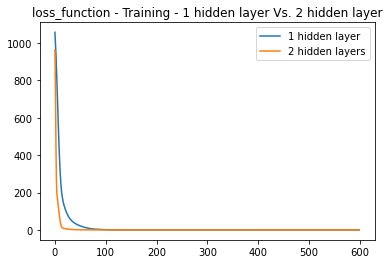

In [137]:
# Plot the loss function of the training results for the two models
plt.plot(model_1.history["loss"])
plt.plot(model_2.history["loss"])
plt.title("loss_function - Training - 1 hidden layer Vs. 2 hidden layer")
plt.legend(["1 hidden layer", "2 hidden layers"])
plt.show()

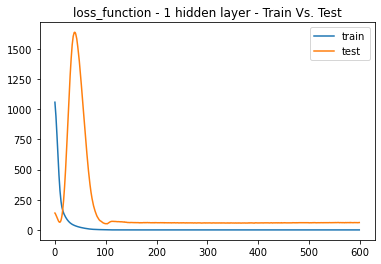

In [138]:
# Plot train vs test for shallow net
plt.plot(model_1.history["loss"])
plt.plot(model_1.history["val_loss"])
plt.title("loss_function - 1 hidden layer - Train Vs. Test")
plt.legend(["train", "test"])
plt.show()

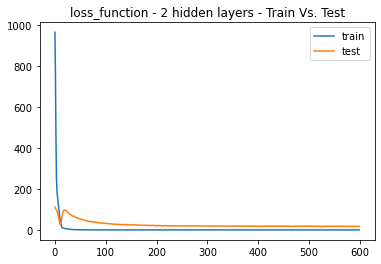

In [139]:
# Plot train vs test for deep net
plt.plot(model_2.history["loss"])
plt.plot(model_2.history["val_loss"])
plt.title("loss_function - 2 hidden layers - Train Vs. Test")
plt.legend(["train", "test"])
plt.show()

In [140]:
# Define the model - deep neural network with two layers
nn = Sequential()

# First hidden layer
nn.add(Dense(units=9, input_dim=9, activation="relu"))

# Second hidden layer
nn.add(Dense(units=6, activation="relu"))

nn.add(Dense(units=3, activation="relu"))

# Output layer
nn.add(Dense(units=1, activation="linear"))

# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model
model_3 = nn.fit(X, y, validation_split=0.3, epochs=600, verbose=0)

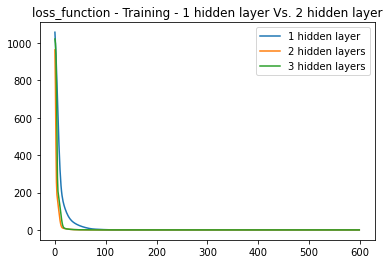

In [141]:
# Plot the loss function of the training results for the two models
plt.plot(model_1.history["loss"])
plt.plot(model_2.history["loss"])
plt.plot(model_3.history["loss"])
plt.title("loss_function - Training - 1 hidden layer Vs. 2 hidden layer")
plt.legend(["1 hidden layer", "2 hidden layers", "3 hidden layers"])
plt.show()

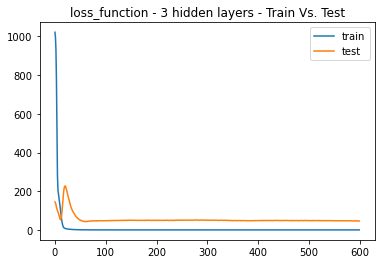

In [142]:
# Plot train vs test for deep net
plt.plot(model_3.history["loss"])
plt.plot(model_3.history["val_loss"])
plt.title("loss_function - 3 hidden layers - Train Vs. Test")
plt.legend(["train", "test"])
plt.show()

#### Split Data Between Training and Testing Sets

To avoid the dataset being randomized, manually create the training and testing sets using array slicing. Use 70% of the data for training and the remainder for testing.

In [143]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y = np.array(y).reshape(-1, 1)
y_train = y[: split]
y_test = y[split:]

#### Scale Data with `MinMaxScaler`

Before training the RNN LSTM model, use the `MinMaxScaler` from `sklearn` to scale the training and testing data between `0` and `1`.

**Note:** You need to scale both features and target sets.

In [144]:
y

array([[19.040001],
       [19.129999],
       [19.23    ],
       ...,
       [43.029999],
       [65.010002],
       [76.790001]])

In [145]:

y

array([[19.040001],
       [19.129999],
       [19.23    ],
       ...,
       [43.029999],
       [65.010002],
       [76.790001]])

In [146]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

#### Reshape Features Data for the LSTM Model

The LSTM API from Keras needs to receive the features data as a _vertical vector_, so that reshape the `X` data in the form `reshape((X_train.shape[0], X_train.shape[1], 1))`. Both sets, training, and testing should be reshaped.

In [147]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.3832116 ]
  [0.31200867]
  [0.37176808]
  [0.36182504]
  [0.30660832]
  [0.03262608]
  [0.30693737]
  [0.30659094]
  [0.42793798]]

 [[0.38304975]
  [0.3117723 ]
  [0.37150325]
  [0.36154648]
  [0.30584686]
  [0.03257453]
  [0.30617985]
  [0.30583837]
  [0.44554475]]

 [[0.38292075]
  [0.31163374]
  [0.37126287]
  [0.36130674]
  [0.30527817]
  [0.03243914]
  [0.30558374]
  [0.30530783]
  [0.46547484]]] 

X_test sample values:
[[[0.39358844]
  [0.29612725]
  [0.54846419]
  [0.36314803]
  [0.29221768]
  [0.01623389]
  [0.28779096]
  [0.29738061]
  [0.48167355]]

 [[0.39282055]
  [0.29565451]
  [0.54762122]
  [0.36258235]
  [0.2914755 ]
  [0.0170285 ]
  [0.28731729]
  [0.29637245]
  [0.43751689]]

 [[0.39202954]
  [0.2950473 ]
  [0.54677235]
  [0.36199849]
  [0.29017427]
  [0.01558915]
  [0.28559946]
  [0.2955257 ]
  [0.42416244]]]


---

### Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.

You will need to:

1. Define the model architecture in Keras.

2. Compile the model.

3. Fit the model with the training data.

In [148]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#### Create the LSTM RNN Model Structure


In [149]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 9
dropout_fraction = 0.33

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

#### Compile the LSTM RNN Model

Compile the model using the `adam` optimizer, and `mean_square_error` as loss function since the value you want to predict is continuous.

In [150]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [151]:
# Show the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 9, 9)              396       
_________________________________________________________________
dropout (Dropout)            (None, 9, 9)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 9, 9)              684       
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 9)                 684       
_________________________________________________________________
dropout_2 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

#### Train the Model

Train (fit) the model with the training data using `10` epochs and a `batch_size=90`. Since you are working with time-series data, remember to set `shuffle=False` since it's necessary to keep the sequential order of the data.

In [152]:
# Train the model
model.fit(X_train, y_train, epochs=600, shuffle=False, batch_size=64, verbose=1)

Epoch 1/600
29/29 [==============================] - 5s 7ms/step - loss: 0.0934
Epoch 2/600
29/29 [==============================] - 0s 6ms/step - loss: 0.0233
Epoch 3/600
29/29 [==============================] - 0s 7ms/step - loss: 0.0252
Epoch 4/600
29/29 [==============================] - 0s 7ms/step - loss: 0.0223
Epoch 5/600
29/29 [==============================] - 0s 7ms/step - loss: 0.0203
Epoch 6/600
29/29 [==============================] - 0s 7ms/step - loss: 0.0178
Epoch 7/600
29/29 [==============================] - 0s 6ms/step - loss: 0.0160
Epoch 8/600
29/29 [==============================] - 0s 7ms/step - loss: 0.0142
Epoch 9/600
29/29 [==============================] - 0s 7ms/step - loss: 0.0134
Epoch 10/600
29/29 [==============================] - 0s 7ms/step - loss: 0.0124
Epoch 11/600
29/29 [==============================] - 0s 7ms/step - loss: 0.0119
Epoch 12/600
29/29 [==============================] - 0s 7ms/step - loss: 0.0106
Epoch 13/600
29/29 [=================

---

### Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:

1. Evaluate the model using the `X_test` and `y_test` data.

2. Use the `X_test` data to make predictions.

3. Create a DataFrame of Real (`y_test`) vs. predicted values.

4. Plot the real vs. predicted values as a line chart.

#### Evaluate the Model

Use the `evaluate()` method of the model using the testing data.

In [153]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.006063208915293217

In [154]:
# Get importance/ranking of features (trading signals) using coefficient
# get importance
#importance = model.coef_
# summarize feature importance
#for i,v in enumerate(importance):
	# print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#pyplot.bar([x for x in range(len(importance))], importance)
#pyplot.show()


#### Make Predictions

Use the `predict()` method of the model to make some closing gold price predictions using your brand new LSTM RNN model and your testing data. Save the predictions in a variable called `predicted`.

In [155]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [156]:
# Recover the original prices instead of the scaled veRSIon
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [157]:
# Create a DataFrame of Real and Predicted values
actual_vs_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = features_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
actual_vs_predicted.tail()

,Actual,Predicted
index,,
2021-01-19,39.360001,29.014004
2021-01-20,39.119999,30.764473
2021-01-21,43.029999,33.259403
2021-01-22,65.010002,40.361889
2021-01-25,76.790001,46.846165


<AxesSubplot:title={'center':'Actual Vs. Predicted Prices'}, xlabel='index'>

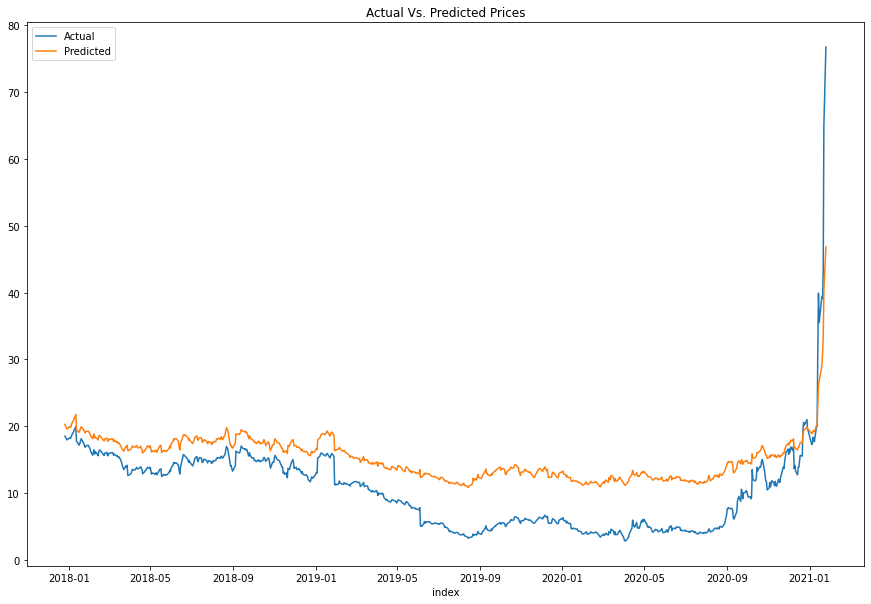

In [158]:
# Plot the real vs predicted prices as a line chart
actual_vs_predicted.plot(title="Actual Vs. Predicted Prices", figsize=(15, 10))

In [159]:
#nn_json = nn.to_json()
#nn_json

#filepath = Path('deep_model.json')
#filepath = 'deep_model.json'
#with open(filepath, 'w') as json_file:
#  json_file.write(nn_json)
#filepath = 'deep_model.h5'
#nn.save_weights(filepath)
#from tensorflow.keras.models import model_from_json
#filepath = 'deep_model.json'
#with open(filepath, 'r') as json_file:
#  model_json = json_file.read()

#loaded_model = model_from_json(model_json)
#filepath = 'deep_model.h5'
#loaded_model.load_weights(filepath)
#actual_vs_predicted['Predicted'] = loaded_model.predict(X)